In [4]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [25]:
# Import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

In [7]:
# Read dataset
online = pd.read_csv('data.csv', encoding = "ISO-8859-1")
# Convert InvoiceDate from object to datetime format
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [8]:
print('{:,} rows; {:,} columns'
      .format(online.shape[0], online.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(online[online.CustomerID.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(online['InvoiceDate'].min(),
                                    online['InvoiceDate'].max()))

541,909 rows; 8 columns
135,080 transactions don't have a customer id
Transactions timeframe from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [16]:
# Drop NA values from online
online.dropna()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [13]:
# Create TotalSum column for online dataset
online['TotalSum'] = online['Quantity'] * online['UnitPrice']
# Create snapshot date
snapshot_date = online['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [23]:
# Grouping by CustomerID
data_process = online.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})
#print(data_process)
# Rename the columns 
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)
#print(data_process)
#Need to understand what we did for Invoice date

In [22]:
# Print top 5 rows and shape of dataframe
print(data_process.head())
print('{:,} rows; {:,} columns'
      .format(data_process.shape[0], data_process.shape[1]))

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           2        182        4310.00
12348.0          75         31        1797.24
12349.0          19         73        1757.55
12350.0         310         17         334.40
4,372 rows; 3 columns


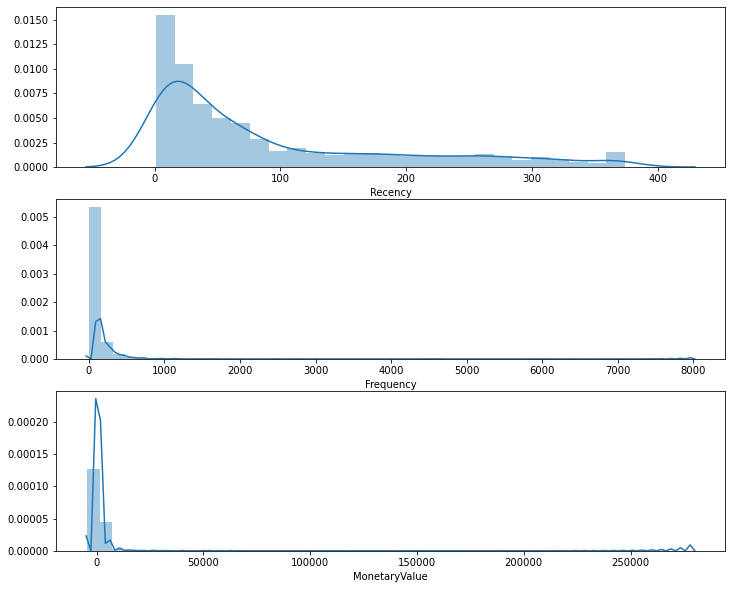

In [26]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

#What is plt.subplot doing????

In [29]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

#Need to understand the range, why did we do 4,0,-1. Higher number should get lower range thats why!! 

,Recency,Frequency,MonetaryValue,R,F
CustomerID,,,,,
12346.0,326,2,0.00,1,1
12347.0,2,182,4310.00,4,4
12348.0,75,31,1797.24,2,2
12349.0,19,73,1757.55,3,3
12350.0,310,17,334.40,1,1


In [30]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [31]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

#what is happening in .apply???

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,111
12347.0,2,182,4310.00,4,4,4,444
12348.0,75,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,310,17,334.40,1,1,2,112


In [32]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

62


In [33]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CustomerID
12346.0     3.0
12347.0    12.0
12348.0     8.0
12349.0    10.0
12350.0     4.0
Name: RFM_Score, dtype: float64


In [34]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3.0,Require Activation
12347.0,2,182,4310.00,4,4,4,444,12.0,Can't Loose Them
12348.0,75,31,1797.24,2,2,4,224,8.0,Champions
12349.0,19,73,1757.55,3,3,4,334,10.0,Can't Loose Them
12350.0,310,17,334.40,1,1,2,112,4.0,Needs Attention


In [36]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Can't Loose Them      25.2     195.1        4130.3  1690
Champions             62.7      57.0         974.7   467
Loyal                 78.8      39.7         724.2   447
Needs Attention      174.5      13.9         227.1   391
Potential             94.3      28.5         491.8   468
Promising            153.0      21.2         346.8   517
Require Activation   264.8       7.8         109.1   392


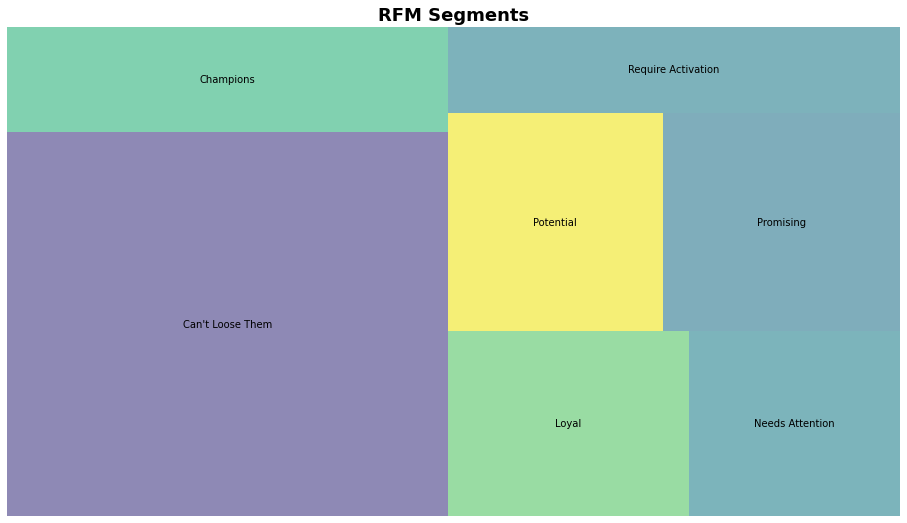

In [37]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()